In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_validate, RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import median_absolute_error, mean_squared_error, r2_score


from urbana.constants import DIR_REPO, DIR_DATA

In [2]:
# papermill parameters cell
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html

MIN_LISTINGS_PER_NEIGHBOURHOOD = 20

ACTIVATE_THRESHOLD = False

In [3]:
neigh = pd.read_csv(
    DIR_DATA / "interim/neigh.csv",
)

neigh.set_index("N_neighbourhood", inplace=True)

neigh.drop(['N_district', 'Neighbourhood', 'District'], axis=1, inplace=True)

if ACTIVATE_THRESHOLD:
    neigh = neigh[neigh['Airbnb_Number'] > MIN_LISTINGS_PER_NEIGHBOURHOOD]

neigh

,Mean_Income_Year,Population_Female,Population_0_15,Population_16_25,Population_26_65,Population_66_Plus,POI_Daily_Food,POI_Daily_Others,POI_House_Equipment,POI_Clothing,...,Nationality_Bangladesh,Nationality_Georgia,Nationality_Armenia,Nationality_Japan,Nationality_Nepal,Nationality_Oceania,Rent_Number,Rent_Price,Rent_Price_Area,Rent_Area
N_neighbourhood,,,,,,,,,,,,,,,,,,,,,
1,9001.176987,0.458032,0.136511,0.112985,0.637792,0.112712,484,81,84,191,...,0.059717,0.001302,0.000924,0.000840,0.003088,0.000693,2003,748.579486,13.915648,59.218221
2,11978.842548,0.479890,0.089155,0.115365,0.665235,0.130245,106,74,46,443,...,0.006226,0.001806,0.000560,0.002490,0.000872,0.002117,808,973.270161,14.191885,77.628242
3,11548.549280,0.502867,0.089891,0.101160,0.631635,0.177314,101,20,8,25,...,0.001000,0.000600,0.000533,0.000734,0.001400,0.002134,857,745.814714,19.844592,40.104113
4,12657.310286,0.502267,0.103473,0.104353,0.655561,0.136614,210,56,52,284,...,0.001981,0.002025,0.000352,0.003037,0.000264,0.002069,1309,916.652697,15.713611,66.137255
5,16376.465455,0.529798,0.122314,0.092454,0.581928,0.203305,136,53,72,58,...,0.001093,0.001000,0.000312,0.000781,0.000718,0.000281,1054,900.418197,13.114796,74.004119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,17323.097293,0.508475,0.205077,0.065962,0.588304,0.140656,36,22,7,74,...,0.000000,0.000660,0.000660,0.000660,0.000000,0.000367,394,1092.062970,16.031175,94.374172
70,9605.617715,0.495241,0.153201,0.103481,0.570386,0.172932,106,24,11,12,...,0.001043,0.002564,0.001173,0.000087,0.002651,0.000043,354,613.031243,10.031687,62.358974
71,14038.842876,0.517645,0.148631,0.090887,0.591204,0.169278,34,24,13,8,...,0.000098,0.001757,0.001025,0.000049,0.000537,0.000049,427,932.015902,12.935797,72.045213


# Train and Test

In [4]:
np.random.seed(42)

X = neigh.loc[:, neigh.columns != 'Airbnb_Number']
y = neigh['Airbnb_Number']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)

## Fit a pipeline with "IterativeImputer", "StandardScaler" and "LinearRegression"

In [5]:
pipe = Pipeline([
    ('imputer',IterativeImputer()),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', IterativeImputer()), ('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [6]:
y_train_pred = pipe.predict(X_train)
mae_train = median_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

y_test_pred = pipe.predict(X_test)
mae_test = median_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

train_test_metrics = {'Train': [mae_train, mse_train, r2_train], 'Test': [mae_test, mse_test, r2_test]}
train_test_metrics = pd.DataFrame(data=train_test_metrics)
train_test_metrics.index=list(['MAE', 'MSE', 'R2'])
train_test_metrics

,Train,Test
MAE,3.410605e-13,134.260445
MSE,2.969427e-25,381162.303025
R2,1.000000e+00,-1.233161


## Visualize coefficients

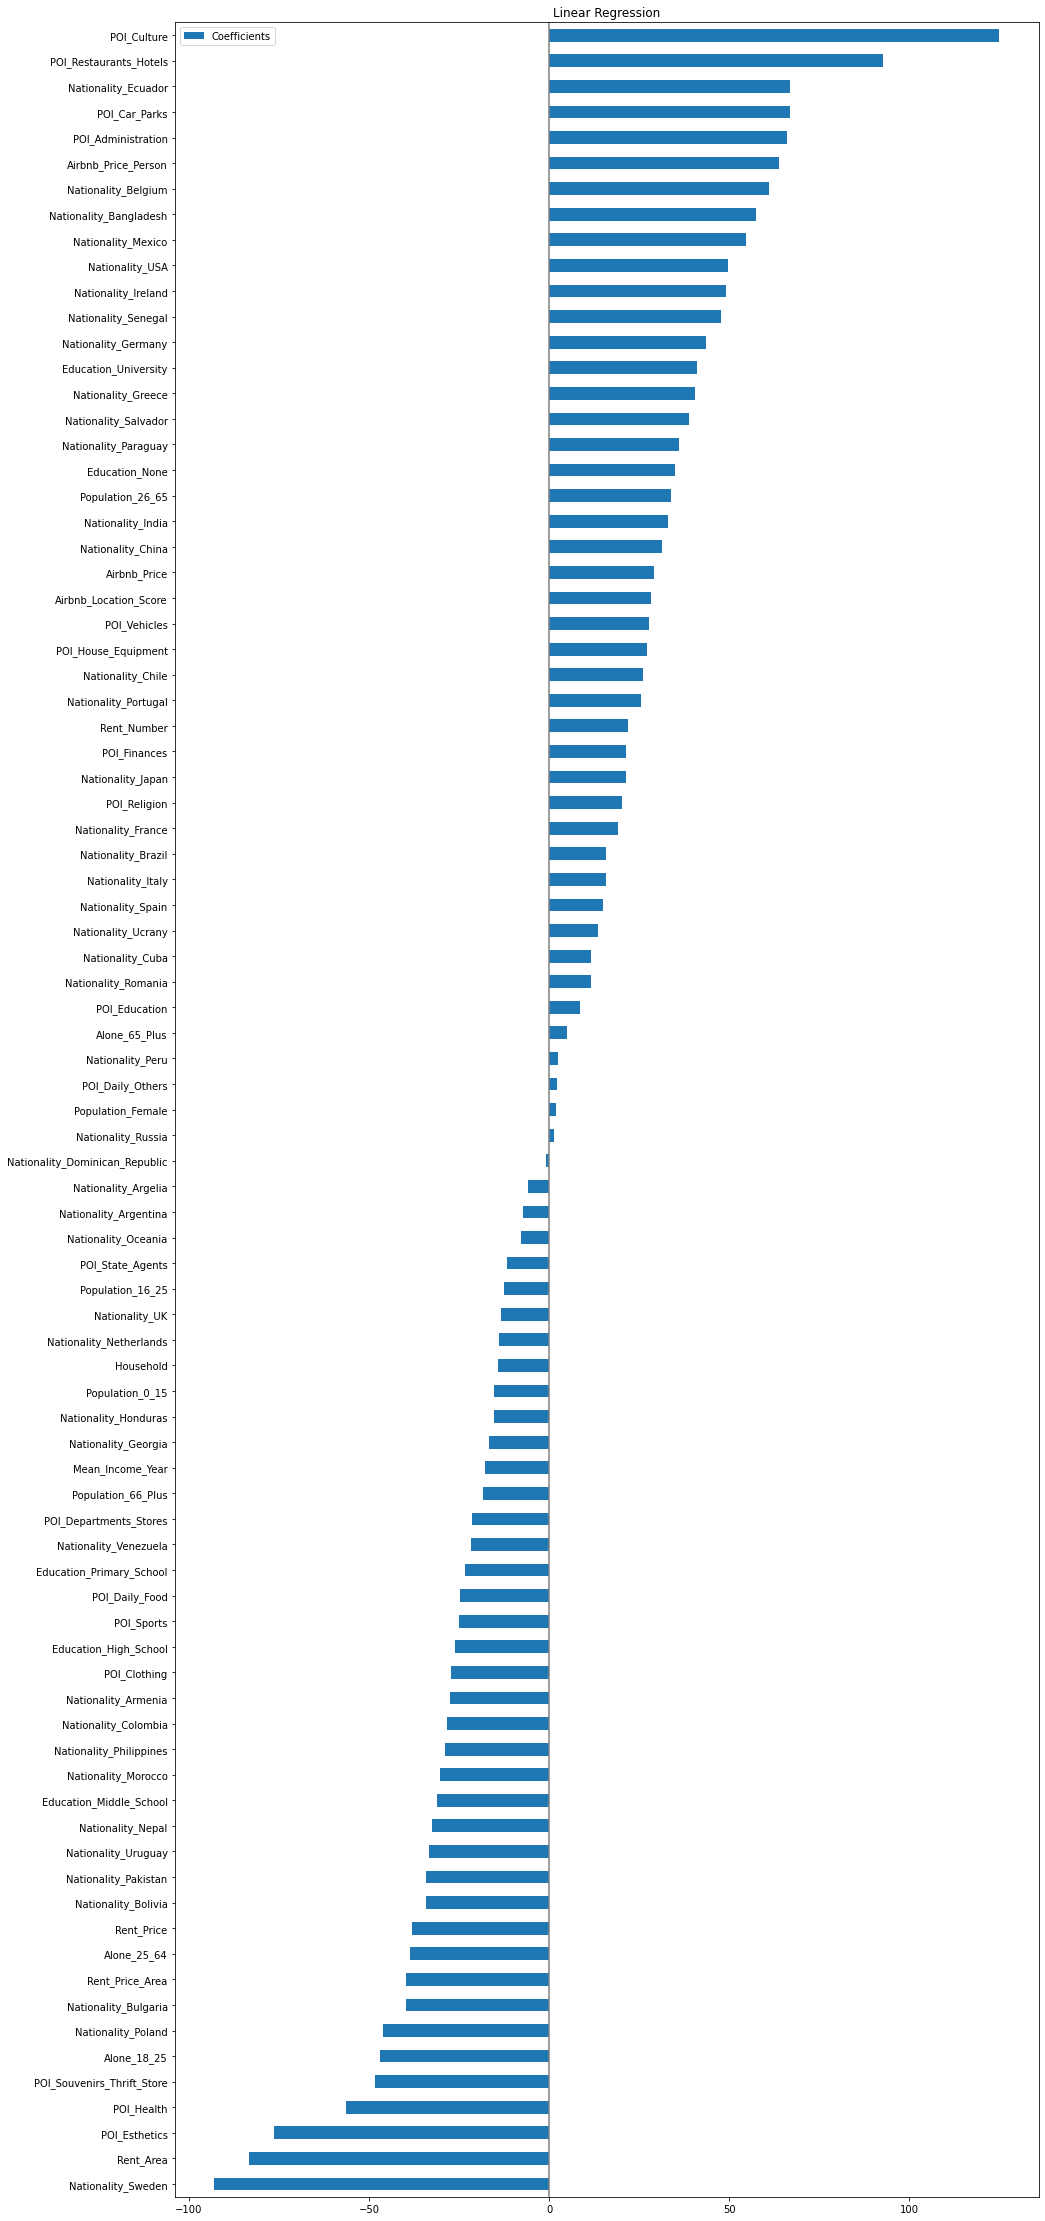

In [7]:
coefs = pd.DataFrame(
    pipe.named_steps['regressor'].coef_,
    columns=['Coefficients'], index=X_train.columns
)

coefs.sort_values(by=['Coefficients'],inplace=True)

coefs.plot(kind='barh', figsize=(20, 40))
plt.title('Linear Regression')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

# plt.savefig('coefficients.jpg')

# Cross-Validation

## Sensibility Analysis

In [8]:
cv_pipe = cross_validate(
    pipe, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
    scoring=['neg_median_absolute_error', 'neg_mean_squared_error', 'r2'],
    return_estimator=True, n_jobs=-1
)

In [9]:
new_coefs = pd.DataFrame(
    [est.named_steps['regressor'].coef_ for est in cv_pipe['estimator']],
    columns=X_train.columns
)

new_coefs = new_coefs[coefs.index]

new_coefs

,Nationality_Sweden,Rent_Area,POI_Esthetics,POI_Health,POI_Souvenirs_Thrift_Store,Alone_18_25,Nationality_Poland,Nationality_Bulgaria,Rent_Price_Area,Alone_25_64,...,Nationality_USA,Nationality_Mexico,Nationality_Bangladesh,Nationality_Belgium,Airbnb_Price_Person,POI_Administration,POI_Car_Parks,Nationality_Ecuador,POI_Restaurants_Hotels,POI_Culture
0,-100.187107,-80.037674,-95.137050,-56.577887,-44.037466,-28.516256,-47.013270,-34.226117,-48.544548,-35.778749,...,51.677321,50.408596,52.266216,58.143630,69.778856,54.687024,57.376963,68.994847,85.470894,129.931304
1,-41.522437,-23.190075,-46.188226,-104.159851,10.331344,50.272544,30.873933,-42.943492,16.060106,-37.585219,...,38.561737,47.100302,0.136061,-3.986244,45.023841,47.975349,110.118901,-72.132528,132.259562,50.011946
2,-87.820376,-30.775796,-77.515628,-55.497069,132.116833,-3.491381,-7.648482,-2.120928,7.100312,-60.392912,...,-4.929970,17.241830,-68.361736,36.738781,19.374355,-21.108657,21.469872,12.643373,110.391142,14.454409
3,-71.564700,8.959571,-119.983565,-118.541090,74.745218,-79.135979,-15.143989,-35.435598,-26.872919,-47.826405,...,16.911131,-48.635211,-31.353110,-36.934595,41.002841,46.891787,37.036581,98.196996,129.311791,83.198116
4,27.115437,-19.172325,-60.618904,-123.842292,86.543185,-49.319630,-18.029053,-27.300001,-52.270103,-132.200378,...,51.966119,36.228762,-6.726879,115.428687,-25.581568,38.367886,10.977379,24.797927,225.509433,31.854959
5,3.641335,19.914948,-95.687773,-57.343135,48.714334,7.503488,-56.056875,-45.810407,-71.401232,-50.569399,...,-11.576028,-121.124935,-42.930049,85.622979,19.253811,46.079707,20.953786,-5.747266,115.056877,108.102533
6,-124.415888,-54.113152,-132.513203,-153.876727,80.336180,-105.688644,-55.197493,-30.173315,51.606882,-78.028515,...,71.343821,65.566063,-46.505397,77.488110,-28.289203,47.861336,41.785516,-91.554709,136.490852,98.233668
7,-99.082396,-79.698115,-88.889932,-119.690693,84.231159,-38.416002,30.902853,-33.015400,-37.181381,-6.049386,...,14.108239,-8.281992,-53.175623,51.038645,43.628016,49.424938,78.244970,47.099900,39.182250,114.916211
8,-62.906843,-56.618189,-130.178842,-57.037478,71.533050,-56.672396,-93.501076,-72.051314,-15.562341,-54.412630,...,22.057619,61.874841,62.392122,-1.403674,58.112872,14.525015,75.064796,-2.617657,122.176127,66.482193
9,-100.671611,-31.763509,-43.286380,-125.992234,108.482445,-22.473261,-3.036903,-9.933805,-11.492252,-90.464787,...,23.869059,-14.605619,-26.284876,-7.198580,-1.276506,18.748976,-13.838865,-15.069839,128.939009,-23.555515


<AxesSubplot:>

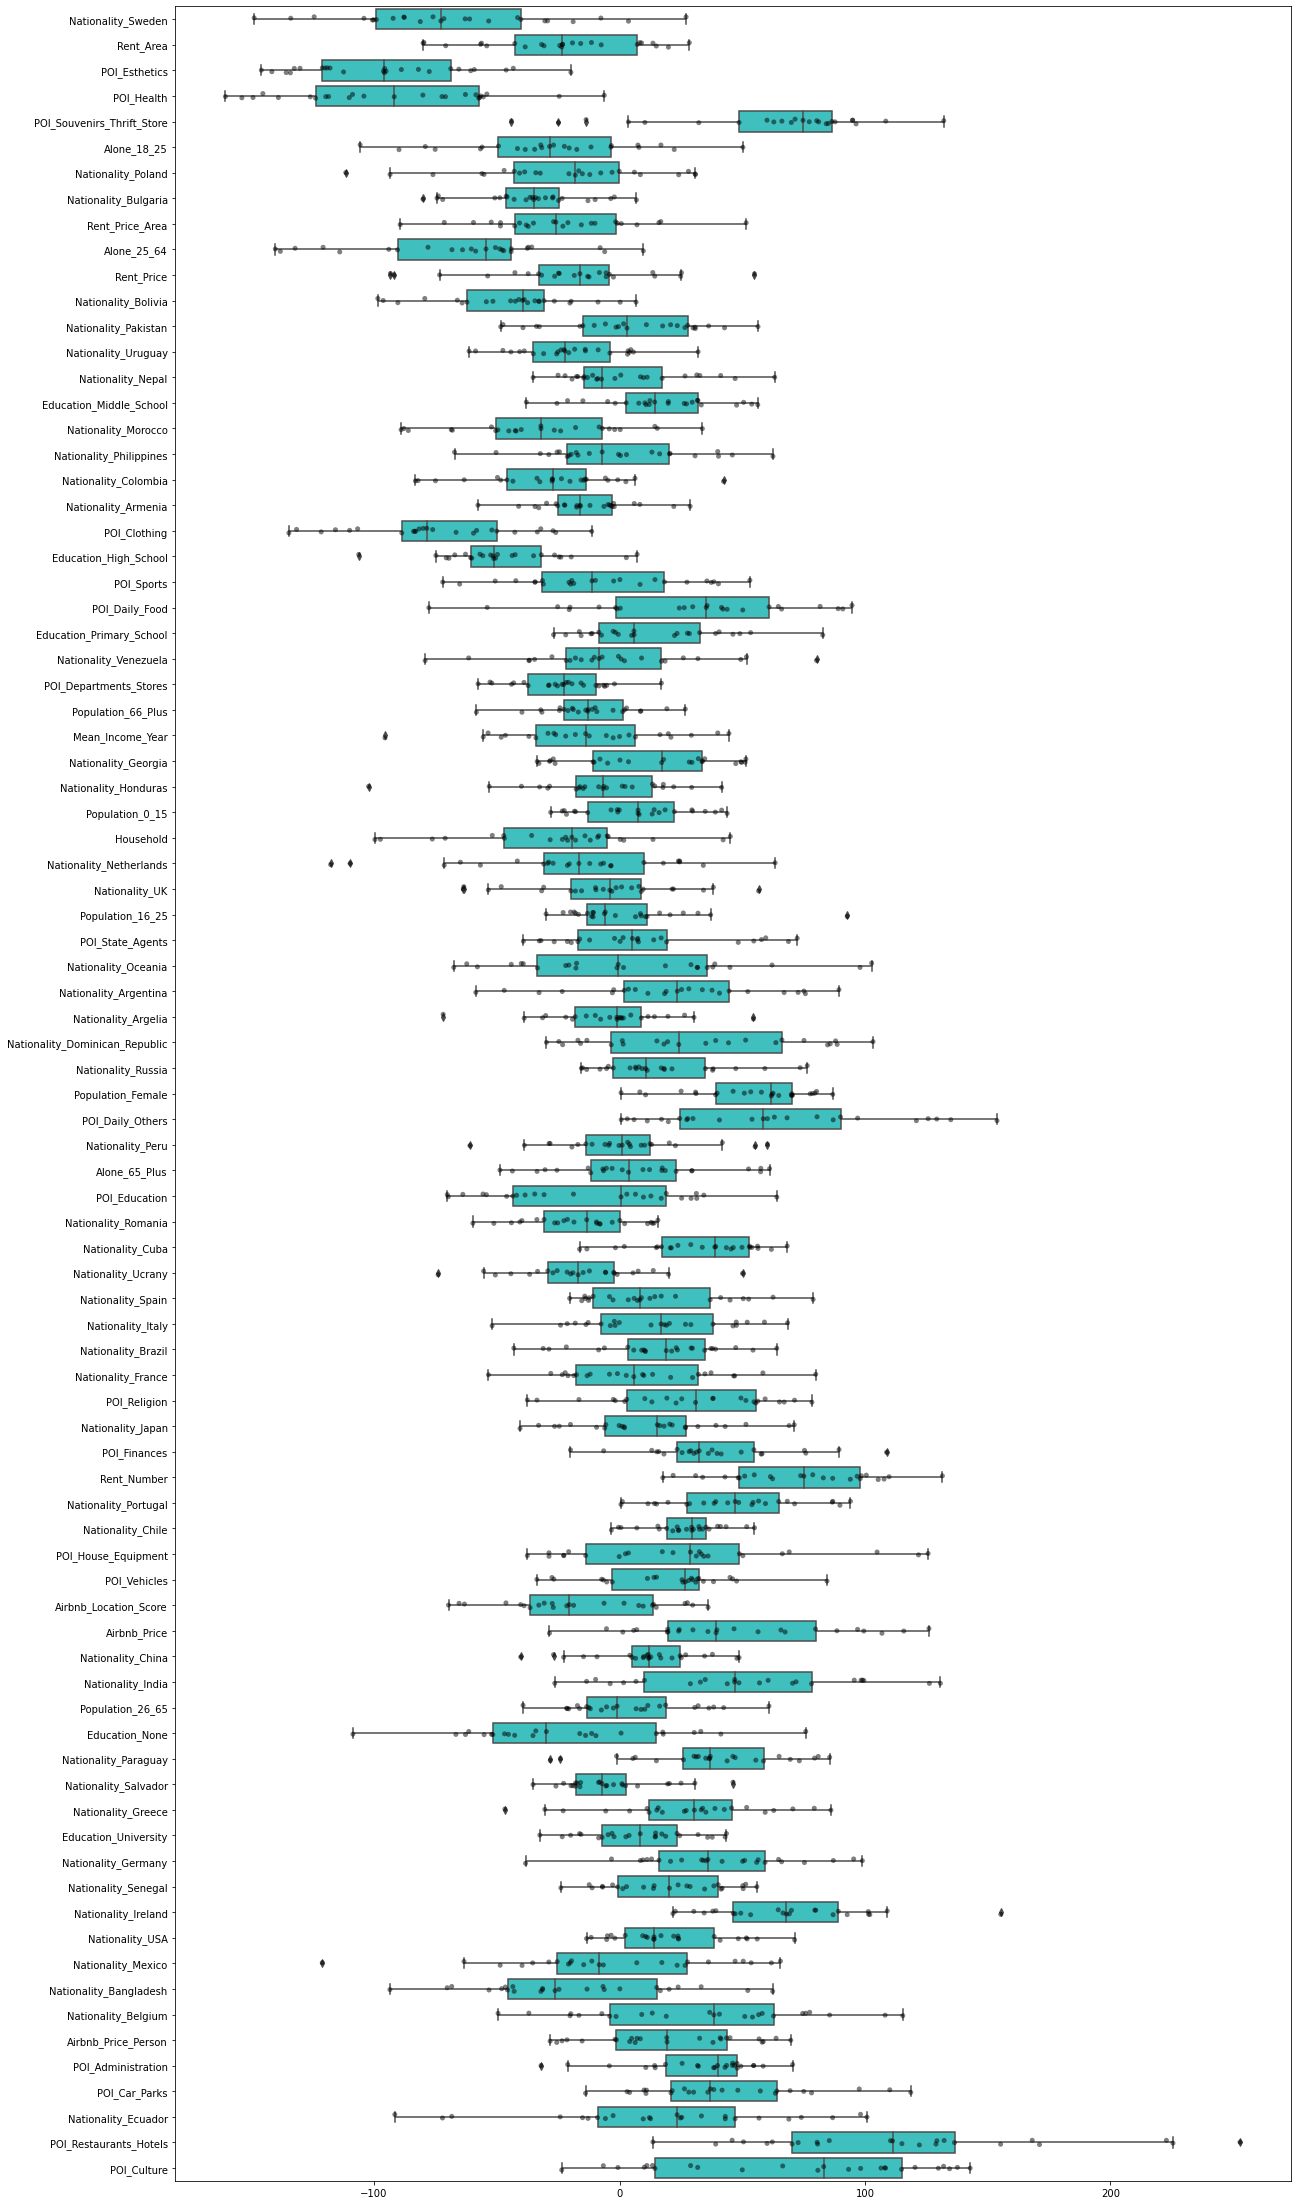

In [10]:
plt.figure(figsize=(20, 40))
sns.stripplot(data=new_coefs, orient='h', color='k', alpha=0.5)
sns.boxplot(data=new_coefs, orient='h', color='cyan', saturation=0.5)

# plt.savefig('sensibility.jpg')

In [11]:
mae_kfold = -cv_pipe['test_neg_median_absolute_error'].mean()
mse_kfold = -cv_pipe['test_neg_mean_squared_error'].mean()
r2_kfold = cv_pipe['test_r2'].mean()

kfold_metrics = {'K-Fold': [mae_kfold, mse_kfold, r2_kfold]}
kfold_metrics = pd.DataFrame(data=kfold_metrics)
kfold_metrics.index=list(['MAE', 'MSE', 'R2'])
kfold_metrics

,K-Fold
MAE,129.689714
MSE,96362.299885
R2,-0.363848


In [12]:
print("Metrics for Train and Test")
print(train_test_metrics)
print("\nMetrics for K-Fold")
print(kfold_metrics)

Metrics for Train and Test
            Train           Test
MAE  3.410605e-13     134.260445
MSE  2.969427e-25  381162.303025
R2   1.000000e+00      -1.233161

Metrics for K-Fold
           K-Fold
MAE    129.689714
MSE  96362.299885
R2      -0.363848
